# Churn Prediction

In this notebook we will make a churn prediction model using a retail dataset. Let's start importing necessary packages for the analysis.

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import joblib
sns.set_style("darkgrid")

import warnings
warnings.filterwarnings("ignore")

# Exploratory Data Analysis
The dataset consist of eight tables in separate .csv files, we will go through six of them which we will use in this notebook. The dataset covers a two year span purchase transactions of various customers. Also demographics information of customers, campaign and coupon redemption information is available. In the modeling phase we will join these tables to make our final dataset.

* Campaign Descriptions (campaigndesc.csv)
* Campaigns (campaign_table.csv)
* Coupons (coupon.csv)
* Coupon Redemptions (coupon_redempt.csv)
* Transactions (transaction_data.csv)
* Demographics (hh_demographic.csv)

## Campaign Descriptions
Campaign description data is a look up table, containing the start and the end days of each campaign

In [3]:
dfs = dict()
dfs["campaign_desc"] = pd.read_csv("campaign_desc.csv")
dfs["campaign_desc"].head()

,CAMPAIGN,START_DATE,END_DATE
0,24,10/21/2019,12/20/2019
1,15,7/1/2019,12/9/2019
2,25,10/21/2019,11/22/2019
3,20,9/7/2019,11/16/2019
4,23,10/8/2019,11/15/2019


### Campaign Dataset
Campaign dataset contains identifying information for the marketing campaigns each customer participated in.

In [4]:
dfs["campaign_table"] = pd.read_csv("campaign_table.csv")
dfs["campaign_table"].head()

,customer_id,CAMPAIGN
0,17,26
1,27,26
2,212,26
3,208,26
4,192,26


### Coupons
Is a lookup table which lists all the coupons sent to customers as part of a campaign, as well as the products for which each coupon is redeemable

In [5]:
dfs["coupon"] = pd.read_csv("coupon.csv")
dfs["coupon"].head()

,COUPON_UPC,PRODUCT_ID,CAMPAIGN
0,10000089061,1,4
1,10000089064,2,9
2,10000089073,3,12
3,51800009050,4,28
4,52100000076,5,25


### Coupon Redemptions
Is a data table, gives which customer redeemed what coupon number. Also the day of the redeem and the campaign number is given for each customer.

In [6]:
dfs["coupon_redempt"] = pd.read_csv("coupon_redempt.csv")
dfs["coupon_redempt"].head()

,customer_id,DATE,COUPON_UPC,CAMPAIGN
0,1,2/25/2019,10000085364,8
1,1,2/25/2019,51700010076,8
2,1,3/3/2019,54200000033,8
3,1,8/20/2019,10000085476,18
4,1,8/20/2019,54200029176,18


### Number of Redeems for each Campaign
Most frequent campaigns (18, 13 and 8, all belongs to TypeA) attracts the most number of redeems as expected. The barchart below gives the number of redeems per campaign.

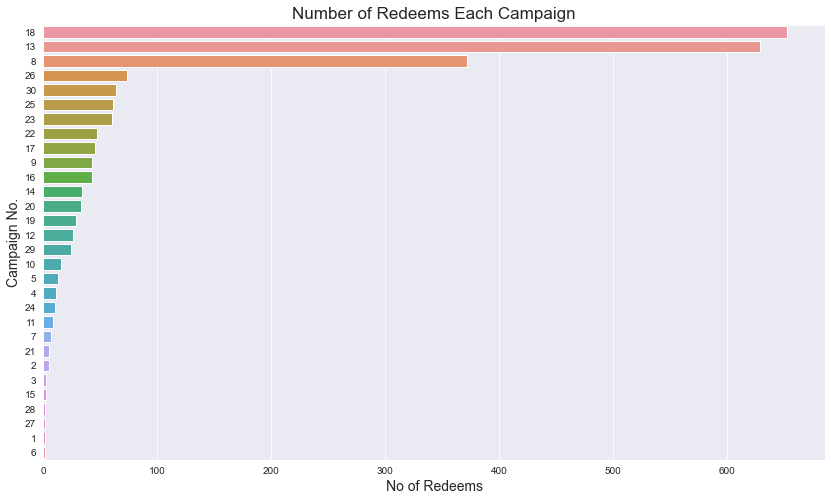

In [7]:
redeem_frequency = pd.DataFrame(list(zip(dfs["coupon_redempt"].CAMPAIGN.value_counts().index, dfs["coupon_redempt"].CAMPAIGN.value_counts())),columns=["Campaign","No of Redeems"])
fig = plt.figure(figsize=(14,8))
sns.barplot(y="Campaign",x="No of Redeems",data = redeem_frequency,orient="h",order=redeem_frequency.Campaign)
plt.title('Number of Redeems Each Campaign', fontsize=17)
plt.xlabel('No of Redeems', fontsize=14)
plt.ylabel('Campaign No.', fontsize=14)
plt.show()

The barchart below gives the redeem rates of each campaign in a descending order. Campaign 13 and 18 are clearly have higher redeem rates (~60%) as compared to the rest of campaigns.

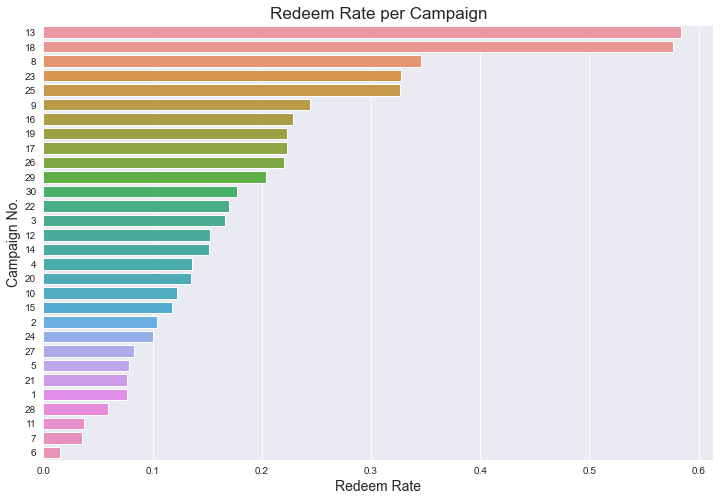

In [8]:

redems_per_camp = dfs["coupon_redempt"].CAMPAIGN.value_counts().sort_values()/dfs["campaign_table"].CAMPAIGN.value_counts().sort_values()
redems_per_camp = pd.DataFrame(list(zip(redems_per_camp.index,redems_per_camp)),
                               columns=["Campaign","Redeem_Rate"]).sort_values(by="Redeem_Rate",ascending=False)
plt.figure(figsize=(12,8))
sns.barplot(y="Campaign",x="Redeem_Rate",data=redems_per_camp,orient="h",order=redems_per_camp.Campaign)
plt.title('Redeem Rate per Campaign', fontsize=17)
plt.xlabel('Redeem Rate', fontsize=14)
plt.ylabel('Campaign No.', fontsize=14)
plt.show()

### Transactional Data
Transactional data contains purchase history of each customer.

In [43]:
import boto3
client = boto3.client('s3')
path = 's3:///adm-project-6/transaction_data.csv'
df = pd.read_csv(path)

In [47]:
df.head()

,customer_id,TRANSACTION_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,WEEK_NO
0,2375,26984851472,1,1004906,1,1.39,1
1,2375,26984851472,1,1033142,1,0.82,1
2,2375,26984851472,1,1036325,1,0.99,1
3,2375,26984851472,1,1082185,1,1.21,1
4,2375,26984851472,1,8160430,1,1.50,1


In [48]:
df_tx = pd.read_csv("transaction_data.csv")
df_tx = df_tx.rename(columns={'household_key': 'customer_id', 'BASKET_ID': 'TRANSACTION_ID'})
dfs["transaction_data"] = df_tx[['customer_id','TRANSACTION_ID','DAY','PRODUCT_ID','QUANTITY','SALES_VALUE','WEEK_NO']]
dfs["transaction_data"].head()

,customer_id,TRANSACTION_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,WEEK_NO
0,2375,26984851472,1,1004906,1,1.39,1
1,2375,26984851472,1,1033142,1,0.82,1
2,2375,26984851472,1,1036325,1,0.99,1
3,2375,26984851472,1,1082185,1,1.21,1
4,2375,26984851472,1,8160430,1,1.50,1


#### Now lets do some descriptive analysis on the transactional data. First, let's group the data by customers:

In [10]:
grouped_sum = dfs["transaction_data"].groupby("customer_id").sum()

#### Average amount of purchase by a customer within these two years is:

In [11]:
av_purc = round(dfs['transaction_data'].SALES_VALUE.sum()/len(grouped_sum),1)
av_purc

3223.0

#### Average total number of products purchased by a customer within two years is:

In [12]:
av_tot_prod = round(grouped_sum["QUANTITY"].mean())
av_tot_prod

104274

#### Average total number of unique products purchased by a customer within two years is:

In [13]:
av_uniq_prod = round(len(dfs["transaction_data"].groupby(["customer_id","PRODUCT_ID"]).sum()["QUANTITY"])/len(grouped_sum))
av_uniq_prod

561

#### Average number of visits per customer within two years is:

In [14]:
av_days_visited = round(len(dfs["transaction_data"].groupby(["customer_id","DAY"]).count())/len(grouped_sum),1)
av_days_visited

90.2

### Top Customers

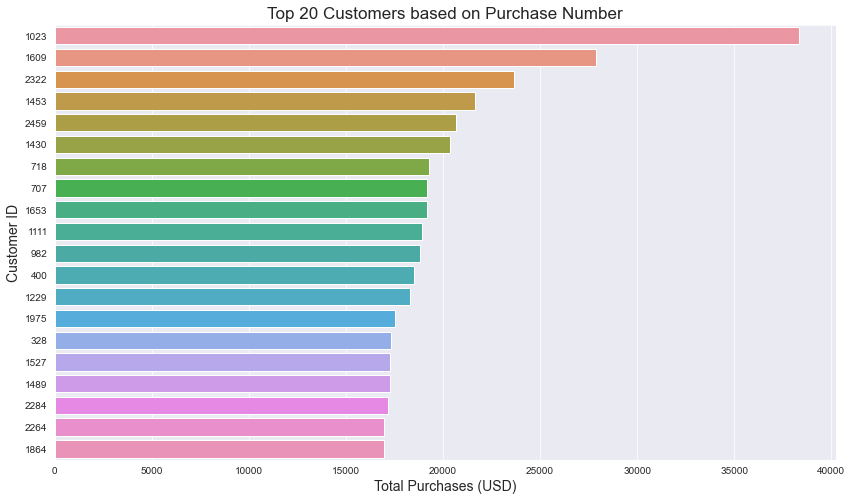

In [15]:
purc_per_cust = dfs["transaction_data"].groupby("customer_id").sum()["SALES_VALUE"].sort_values(ascending=False)
purc_per_cust = pd.DataFrame(list(zip(purc_per_cust.index,purc_per_cust)),columns=["customer_id","Total Purchase (USD)"])
fig_store = plt.figure(figsize=(14,8))
sns.barplot(y="customer_id",x="Total Purchase (USD)",data = purc_per_cust[:20],order=purc_per_cust[:20]["customer_id"],orient="h")
plt.title('Top 20 Customers based on Purchase Number', fontsize=17)
plt.xlabel('Total Purchases (USD)', fontsize=14)
plt.ylabel('Customer ID', fontsize=14)
plt.show()

### Demographics Data
Demographics data contains customer demographical information such as age group, income desc, etc. We will be using this table as a base and add few columns after feature engineering. Target variable for the churn prediction will be added in the final dataset before moving on to the predictive modeling.

In [16]:
dfs["hh_demographic"] = pd.read_csv("hh_demographic.csv")
dfs["hh_demographic"].head()

,AGE_DESC,INCOME_DESC,customer_id
0,65+,35-49K,1
1,45-54,50-74K,7
2,25-34,25-34K,8
3,25-34,75-99K,13
4,45-54,50-74K,16


Lets first start defining the functions for exploratory analysis of demographic variables:

In [17]:
def pie_categorical(data):
    #function to plot the histogram of categorical variables in pie graph
    features = data.columns
    #plot pie charts of categorical variables
    fig_pie_cat = plt.figure(figsize=(15,15))
    count = 1
    #calculate dynamic numbers of subplot rows and columns
    cols = int(np.ceil(np.sqrt(len(features))))
    rows = int(np.ceil(len(features)/cols))
    for i in features:
        ax = fig_pie_cat.add_subplot(rows,cols,count)
        data[i].value_counts().plot(kind="pie",autopct="%.1f%%",ax=ax)
        plt.ylabel("")
        plt.title(i,fontweight="bold",fontsize=8)
        count += 1

def hist_numeric(data):
    #function to plot the histogram of numeric variables
    features = data.columns
    fig_hists = plt.figure(figsize=(15,15))
    fig_hists.subplots_adjust(hspace=0.5,wspace=0.5)
    count = 1
    #calculate dynamic numbers of subplot rows and columns
    cols = int(np.ceil(np.sqrt(len(features))))
    rows = int(np.ceil(len(features)/cols))
    for i in features:
        ax = fig_hists.add_subplot(rows,cols,count)
        data[i].plot(kind="hist",alpha=.5,bins=25,edgecolor="navy",legend=False,ax=ax)
        ax.set_xlabel("")
        ax.set_title(i,fontweight="bold",fontsize=10)
        count += 1


Since all variables are categorical in the demographics dataset, we will use our _piecategorical function. The pie charts below gives the distribution of each categorical variable in the demographics dataset.

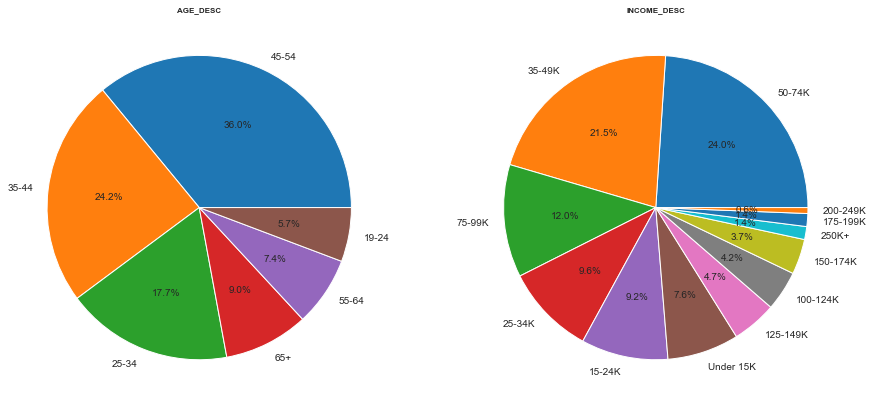

In [18]:
pie_categorical(dfs["hh_demographic"].drop("customer_id",axis=1))

## Churn Prediction
Let's start working on the "Churn Prediction" problem from here.

Datasets have been examined and found out that it does not contain a column which indicates whether customer is churned or not. Therefore we will have to define our own churn definition and move on to the modelling.

A generally accepted retail churn rate is between five to sevent percent per year. Less than five percent is a great goal, but a churn rate over ten percent is cause for concern. Even as you acquire more customers, your business can't grow unless you have a greater volume of incoming customers than outgoing ones.

Satisfying existing customers is actually more profitable than obtaining new ones. **It costs five times more to obtain a new customer than it does to retain an existing customer**. Decreasing your churn rate by five percent increases profits up to 125%.

Let's define transactional churn:

**A customer will be considered as churned if not purchased from a store 2 weeks or more.**

2 weeks out threshold is chosen as it splits customers around 85%/15% No Churn/Churn.

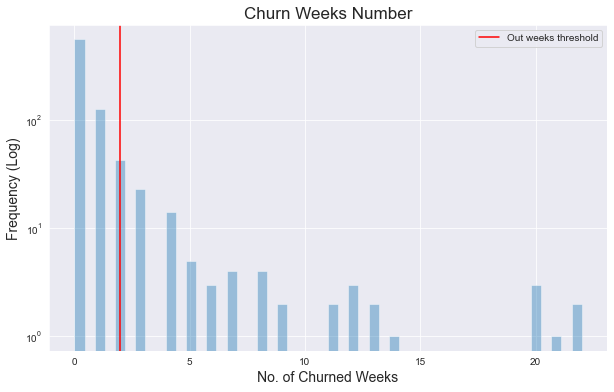

In [19]:
out_weeks_threshold = 2

#weekly customer purchase amount
weekly_purchase = dfs["transaction_data"].groupby(["customer_id","WEEK_NO"]).sum()["SALES_VALUE"]
weekly_purchase = weekly_purchase.unstack()

#customer churned by their last 2 week's purchasing behaviour
target = []
common_cust = set(dfs["hh_demographic"].customer_id) & set(dfs["transaction_data"].customer_id)
for cust in common_cust:
  target.append(102-weekly_purchase.loc[cust].dropna().index[-1])

target = pd.DataFrame(list(zip(common_cust,target)),columns=["customer_id","No. of Churned Weeks"])
plt.figure(figsize=(10,6))
ax = sns.distplot(target["No. of Churned Weeks"],kde=False)
ax.axvline(x=out_weeks_threshold,c="red",label="Out weeks threshold")
ax.legend()
ax.set_yscale("log")
ax.set_ylabel("Frequency (Log)", fontsize=14)
ax.set_xlabel("No. of Churned Weeks", fontsize=14)

plt.title('Churn Weeks Number', fontsize=17)
plt.show()

Now lets generate our target variable for modelling:

* Churned -> True
* Not Churned -> False

In [20]:
target["isChurned"] = target["No. of Churned Weeks"]>=out_weeks_threshold
target.drop("No. of Churned Weeks",axis=1,inplace=True)

Let's see how customers split with the defined churn:

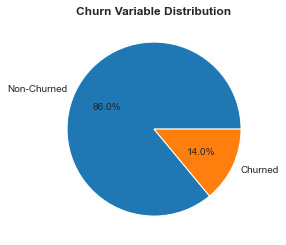

In [21]:
target.isChurned.value_counts().plot(kind="pie",autopct="%.1f%%",labels=["Non-Churned","Churned"])
plt.ylabel("")
plt.title("Churn Variable Distribution",fontweight="bold")
plt.show()

### Feature engineering
Let's generate some features from the "Campaign Table", "Transaction Data" and "Coupon Redempt" tables to be used in the churn prediction model:

**Feature 1**: List of campaigns received by each customer:

In [22]:
total_customers = 2500
customer_per_campaign = dfs["campaign_table"].groupby("CAMPAIGN")["customer_id"].apply(list)
total_campaigns = len(dfs["campaign_table"].CAMPAIGN.unique())
df_camp = pd.DataFrame(np.full((total_customers,total_campaigns),0),columns=["Camp_"+str(i) for i in range(1,total_campaigns+1)],
                                                                                                           index=range(1,total_customers+1))
for camp in customer_per_campaign.index:
    df_camp.loc[customer_per_campaign[camp],"Camp_"+str(camp)] = 1

df_camp["customer_id"] = df_camp.index

**Feature 2**: Total number of received campaigns per customer:

In [23]:
temp = dfs["campaign_table"].customer_id.value_counts().sort_index()
no_of_received_campaigns = pd.DataFrame(list(zip(temp.index,temp.values.astype(int))),columns=["customer_id","no_of_received_campaigns"])

**Feature 3**: List of campaigns resulted in coupon redemption:

In [24]:
temp = dfs["coupon_redempt"].groupby("customer_id")["CAMPAIGN"].apply(list)
rede_camp_history_per_customer = pd.DataFrame(list(zip(temp.index,temp.values)),columns=["customer_id","redeemed_CAMPAIGN_list"])

**Feature 4**: The number of redemptions made by each customer:

In [25]:
temp = dfs["coupon_redempt"].customer_id.value_counts().sort_index()
no_of_rede_per_customer = pd.DataFrame(list(zip(temp.index,temp.values.astype(int))),columns=["customer_id","no_of_redeems"])

**Feature 5:** Amount of purchase of a customer within two years:

In [26]:
purc_per_cust = dfs["transaction_data"].groupby("customer_id").sum()["SALES_VALUE"].sort_values(ascending=False)
purc_per_cust = pd.DataFrame(list(zip(purc_per_cust.index,purc_per_cust)),columns=["customer_id","Total Purchase (USD)"])

### Last touches on the dataset
Generate the final dataframe to be used for predictive modelling

In [27]:
data = pd.merge(dfs["hh_demographic"],df_camp,on="customer_id",how="left")
data = pd.merge(data,no_of_received_campaigns,on="customer_id",how="left")
data = pd.merge(data,no_of_rede_per_customer,on="customer_id",how="left")
data = pd.merge(data,purc_per_cust,on="customer_id",how="left")
data = pd.merge(data,target,on="customer_id",how="left")

In [28]:
data.shape

(801, 37)

In [29]:
data.head()

,AGE_DESC,INCOME_DESC,customer_id,Camp_1,Camp_2,Camp_3,Camp_4,Camp_5,Camp_6,Camp_7,...,Camp_25,Camp_26,Camp_27,Camp_28,Camp_29,Camp_30,no_of_received_campaigns,no_of_redeems,Total Purchase (USD),isChurned
0,65+,35-49K,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,8.0,5.0,4330.16,False
1,45-54,50-74K,7,0,0,0,0,0,0,0,...,0,0,0,0,0,0,4.0,NaN,3400.05,False
2,25-34,25-34K,8,0,0,0,1,1,0,0,...,0,0,0,0,1,0,10.0,1.0,5534.97,False
3,25-34,75-99K,13,0,0,0,1,1,0,0,...,0,0,0,0,0,0,10.0,21.0,13190.92,False
4,45-54,50-74K,16,0,1,0,0,0,0,0,...,0,0,0,0,0,0,2.0,NaN,1512.02,True


Change NaN or None/Unknown values to zero for the columns of "number of received campaigns", "kid category" and the "number of redeems"

In [30]:
data.no_of_received_campaigns.replace(np.nan,0,inplace=True)
data.no_of_received_campaigns = data.no_of_received_campaigns.astype(int)
data.no_of_redeems.replace(np.nan,0,inplace=True)

In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 801 entries, 0 to 800
Data columns (total 37 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   AGE_DESC                  801 non-null    object 
 1   INCOME_DESC               801 non-null    object 
 2   customer_id               801 non-null    int64  
 3   Camp_1                    801 non-null    int32  
 4   Camp_2                    801 non-null    int32  
 5   Camp_3                    801 non-null    int32  
 6   Camp_4                    801 non-null    int32  
 7   Camp_5                    801 non-null    int32  
 8   Camp_6                    801 non-null    int32  
 9   Camp_7                    801 non-null    int32  
 10  Camp_8                    801 non-null    int32  
 11  Camp_9                    801 non-null    int32  
 12  Camp_10                   801 non-null    int32  
 13  Camp_11                   801 non-null    int32  
 14  Camp_12   

Let's see how our features interact with the target variable. Start with the "Age" variable:

* Customers with the age of 55-64 tend to churn less then the rest of other age groups
* No monotonic increase or decrease observed with age

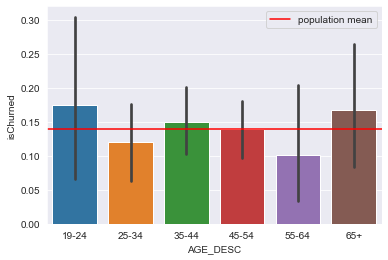

In [32]:
ax = sns.barplot(x="AGE_DESC",y="isChurned",data=data,order=["19-24","25-34","35-44","45-54","55-64","65+"])
ax.axhline(y=data.isChurned.sum()/len(data),c="red",label="population mean")
ax.legend()
plt.show()

Income vs Churn Rate:

* No monotonic increase or decrease observed over the income groups
* However as seen in the barchart below, no churn was observed when a customer's income reaches to 175K and more 

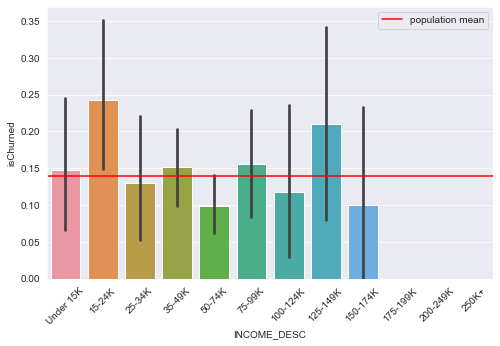

In [33]:
fig = plt.figure(figsize=(8,5))
ax = sns.barplot(x="INCOME_DESC",y="isChurned",data=data,
                 order=["Under 15K","15-24K","25-34K","35-49K","50-74K","75-99K","100-124K","125-149K","150-174K","175-199K","200-249K","250K+"])
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
ax.axhline(y=data.isChurned.sum()/len(data),c="red",label="population mean")
ax.legend()
plt.show()

Number of Redeems vs Churn Rate:

Lets group our data based on customer's number of redeems. We will use pandas.cut which groups the number of redeems into the bins. Graph below separates 0 redeemers, redeemed once and the final group redeemed more than once:

* Churn rate decreases as the number of redeems increase

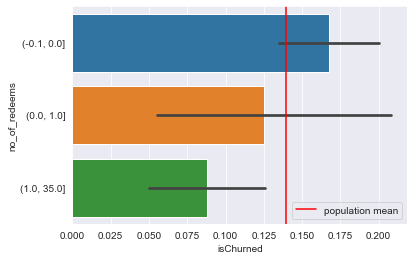

In [34]:
ax = sns.barplot(y=pd.cut(data.no_of_redeems,bins=[-0.1,0,1,35],duplicates="drop"),x="isChurned",data=data,orient="h")
ax.axvline(x=data.isChurned.sum()/len(data),c="red",label="population mean")
ax.legend()
plt.show()

Churn rate vs Number of campaigns used by a customer

* Churn rate decreases as the number of campaigns received by a customer increases

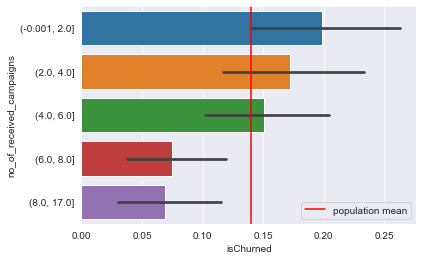

In [35]:
ax = sns.barplot(y=pd.qcut(data.no_of_received_campaigns,5,duplicates="drop"),x="isChurned",data=data,orient="h")
ax.axvline(x=data.isChurned.sum()/len(data),c="red",label="population mean")
ax.legend()
plt.show()

Total purchase of a customer vs Churn rate:

* Total purchase amount of a customer is a clear separator, expected to perform well as a feature in the churn prediction model
* Churn rate decreases as total amount of purchase of a customer (within 2 years) increases

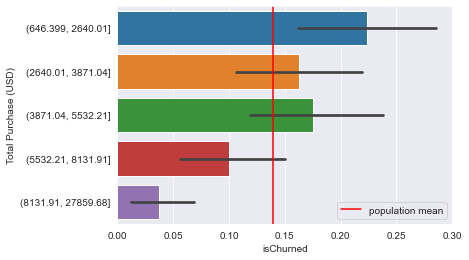

In [36]:
ax = sns.barplot(y=pd.qcut(data["Total Purchase (USD)"],5,duplicates="drop"),x="isChurned",data=data,orient="h")
ax.axvline(x=data.isChurned.sum()/len(data),c="red",label="population mean")
ax.legend()
plt.show()

### ML Model Training & Testing
In this section we will train a Machine Learning model with the training data. The machine learning model is chosen as XGBoost (Extreme Gradient Boosting) as they are known to be performing well with imbalanced datasets like ours.

In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

#one hot encoding categorical data for modelling
encoded = pd.get_dummies(data[data.columns[data.dtypes==object]])
data_encoded = pd.concat([encoded, data[data.columns[data.dtypes != object]]],axis=1)

#Features (X) and the target (y)
X = data_encoded.drop("isChurned",axis=1)
y = data_encoded.isChurned

#lets start with the default hyperparameters and hold-out mechanism for train/test split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25)

#XGBoost
xgb_mdl = XGBClassifier().fit(X_train.values,y_train.values)
xgb_mdl

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [79]:
joblib.dump(xgb_mdl,'Churn_Model')
joblib.dump(X_test,'Churn_Data')

['Churn_Data']

We first transformed our categorical variables using one-hot encoding algorithm (get_dummies) to be able to use in our classifier. Then separated the data into train and test 75%/25%. Then generated an XGBoost classifier with it's default parameters and trained it with the training set.

Now let's test our trained classifier with test data:

Train Data Classification Report:

              precision    recall  f1-score   support

       False       1.00      1.00      1.00       520
        True       1.00      1.00      1.00        80

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600

Test Data Classification Report:

              precision    recall  f1-score   support

       False       0.85      0.96      0.91       169
        True       0.40      0.12      0.19        32

    accuracy                           0.83       201
   macro avg       0.63      0.54      0.55       201
weighted avg       0.78      0.83      0.79       201



[Text(0.5, 16.0, 'predicted values'),
 Text(34.0, 0.5, 'real values'),
 Text(0.5, 1.0, 'Confusion Matrix')]

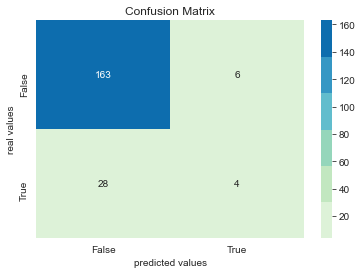

In [38]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, average_precision_score

#XGBoost
y_pred_train = xgb_mdl.predict(X_train.values)
y_pred = xgb_mdl.predict(X_test.values)

print("Train Data Classification Report:\n")
print(classification_report(y_train,y_pred_train))

print("Test Data Classification Report:\n")
print(classification_report(y_test,y_pred))

#generate a confusion matrix to visualise precision, recall, misclassification and false alarms
cm = pd.DataFrame(confusion_matrix(y_test, y_pred), index = list(set(y)), columns = list(set(y)))

#visualise the confusion matrix in the heatmap form
plt.figure()
sns.heatmap(cm, annot = True, fmt="d",
            cmap=sns.color_palette("GnBu")).set(xlabel='predicted values', 
                                                ylabel='real values', 
                                                title = 'Confusion Matrix')

In [39]:
roc_auc_score(y_test,y_pred)
# average_precision_score(y_test,y_pred)

0.5447485207100592

Our target variable is skewed towards not churned (86% are not churned). Even a very basic model which selects majority class all times would score 86% accuracy.

Therefore we will have to focus on how well our model performs on the minority class (churned customers). On the test set we have 201 samples only 23 of them being churned. Our model could not manage to detect any of them, therefore test set recall has come out as 0%. This is the part we need to aim to increase.

Now lets try to enhance our model by optimising hyperparameters by using "Randomised Search" with "Cross-Validation".

We need to determine the evaluation criteria (scorer) to be optimised for the Randomised Search. Lets see the available scorers:

* average precision, balanced accuracy, roc_auc, f1 are the scorers which are commonly used for imbalanced dataset classifications as they handle situation well as compared to other metrics

In [40]:
import sklearn
sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_weighted',
 'v_measure_score']

In [41]:
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, RandomizedSearchCV

#shuffle the dataset to avoiding sampling biases
data = data_encoded.sample(frac=1)
X = data.drop("isChurned",axis=1)
y = data.isChurned

#generate an XGB classifier
mdl = XGBClassifier()

#parameter ranges
param_list = {
    'silent': [False],
    'max_depth': range(2,51),
    'learning_rate': [0.001, 0.01, 0.1, 0.15],
    'subsample': np.arange(0,1.1,.1),
    'colsample_bytree': np.arange(0,1.1,.1),
    'colsample_bylevel': np.arange(0,1.1,.1),
    'min_child_weight': [0.5, 0.7, 1.0, 2.0, 3.0],
    'gamma': [0, 0.25, 0.5, 0.75, 0.9, 1.0],
    'reg_lambda': [0.1, 1.0, 5.0, 10.0, 50.0, 100.0, 500.0, 1000.0],
    'n_estimators': [2, 5, 10, 20, 50, 100],
    'scale_pos_weight': [1, 1.5, 2, 6, 6.1, 6.3, 6.5, 8],
    'max_delta_step': [1, 2, 3, 5, 10]
}

kfold = 5
cv_strat = RepeatedStratifiedKFold(n_splits=kfold,n_repeats=10)

#Randomized Search
cv = RandomizedSearchCV(mdl,param_list,cv=cv_strat,n_iter=100,verbose=1,scoring="balanced_accuracy",n_jobs=-1).fit(X.values,y.values)

#use the best estimator after the hyperparameter optimisation
mdl_best = cv.best_estimator_

OverflowError: Python int too large to convert to C long

In [78]:
joblib.dump(mdl_best,'Best_Churn_Model')

['Best_Churn_Model']

Hyperparameter optimisation is completed. Now lets train and test the XGBoost Classifier with the optimised hyperparameters

Train Data Classification Report:

              precision    recall  f1-score   support

       False       0.93      0.62      0.74       510
        True       0.25      0.72      0.37        90

    accuracy                           0.63       600
   macro avg       0.59      0.67      0.56       600
weighted avg       0.82      0.63      0.69       600

Test Data Classification Report:

              precision    recall  f1-score   support

       False       0.95      0.56      0.71       179
        True       0.18      0.77      0.29        22

    accuracy                           0.59       201
   macro avg       0.57      0.67      0.50       201
weighted avg       0.87      0.59      0.66       201



[Text(33.0, 0.5, 'real values'),
 Text(0.5, 15.0, 'predicted values'),
 Text(0.5, 1.0, 'Confusion Matrix')]

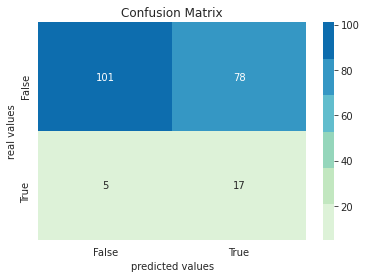

In [80]:
#XGBoost with optimised parameters
b_pred_train = mdl_best.predict(X_train.values)
b_pred = mdl_best.predict(X_test.values)

print("Train Data Classification Report:\n")
print(classification_report(y_train,b_pred_train))

print("Test Data Classification Report:\n")
print(classification_report(y_test,b_pred))

#generate a confusion matrix to visualise precision, recall, misclassification and false alarms
cm = pd.DataFrame(confusion_matrix(y_test, b_pred), index = list(set(y)), columns = list(set(y)))

#visualise the confusion matrix in the heatmap form
plt.figure()
sns.heatmap(cm, annot = True, fmt="d",
            cmap=sns.color_palette("GnBu")).set(xlabel='predicted values', 
                                                ylabel='real values', 
                                                title = 'Confusion Matrix')

In [81]:
cv.best_params_

{'colsample_bylevel': 0.6000000000000001,
 'colsample_bytree': 0.6000000000000001,
 'gamma': 0,
 'learning_rate': 0.001,
 'max_delta_step': 1,
 'max_depth': 19,
 'min_child_weight': 0.7,
 'n_estimators': 20,
 'reg_lambda': 1000.0,
 'scale_pos_weight': 6.1,
 'silent': False,
 'subsample': 0.30000000000000004}

_scale_pos_weight_ is the parameter used for biasing (weighing more) of the minority class samples. The higher the value the more bias towards minority class. In our dataset, the ratio between majority class samples and the minority class is 6.15 which coheres with this parameter (optimised value came out as 6).

Lets test our optimised model with the data:

In [82]:
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate

cv_strat = RepeatedStratifiedKFold(n_splits=kfold,n_repeats=20)
scores = cross_validate(mdl_best,X.values,y.values,cv=cv_strat,verbose=3,n_jobs=-1,return_train_score=True,
                        scoring={"roc_auc":"roc_auc",
                                 "recall":"recall",
                                 "precision":"precision",
                                 "accuracy":"accuracy",
                                 "balanced_accuracy":"balanced_accuracy",
                                 "average_precision":"average_precision"}) 

pd.DataFrame(pd.DataFrame(scores).mean(),columns=["Score"]).drop(["fit_time","score_time"])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.9s finished


,Score
test_roc_auc,0.629414
train_roc_auc,0.753050
test_recall,0.576047
train_recall,0.716137
test_precision,0.193353
train_precision,0.241526
test_accuracy,0.596009
train_accuracy,0.638870
test_balanced_accuracy,0.587681
train_balanced_accuracy,0.671217


Even though getting lower accuracy in total, now we are getting much better results for the minority class as recall and ROC AUC (receiver operating characteristics, area under curve) increased significantly.

The score table above gives all metric results for both test and train sets. Train and test results are close which is an indication that our model did not overfit.

The barchart below list the features ordered by their importance values for the XGB Classifier.

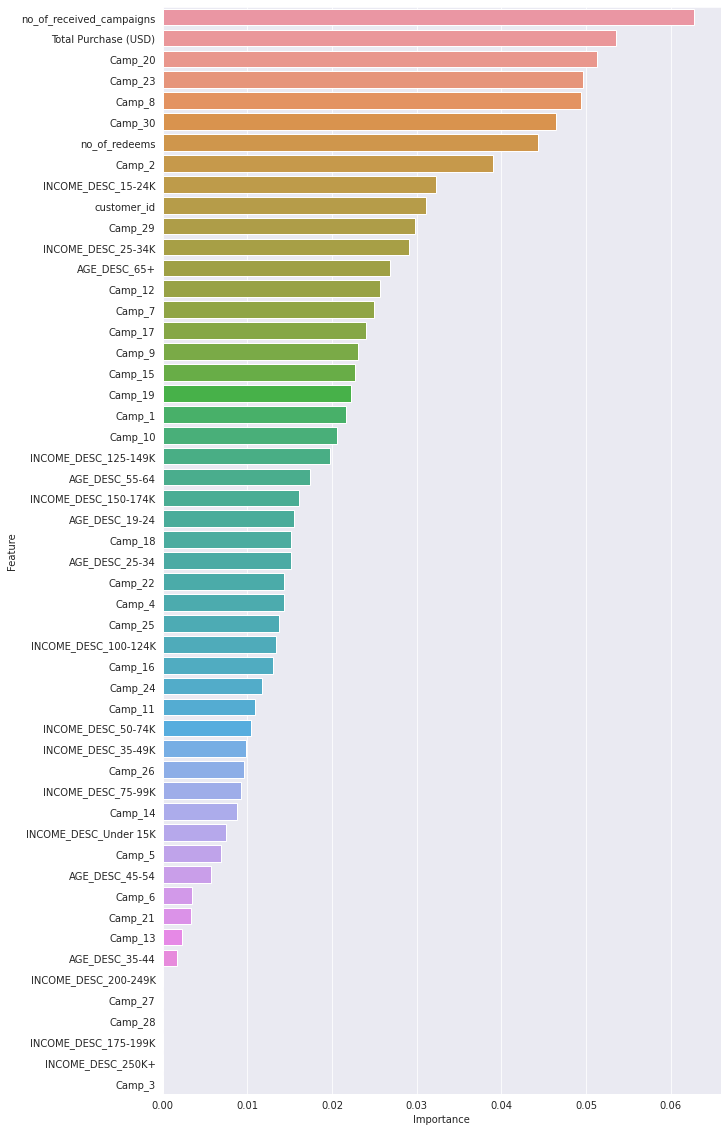

In [83]:
feat_imp = pd.DataFrame(list(zip(data.columns,mdl_best.feature_importances_)),columns=["Feature","Importance"]).sort_values(by="Importance",ascending=False)
fig_store = plt.figure(figsize=(10,20))
sns.barplot(y="Feature",x="Importance",data = feat_imp,orient="h")
plt.show()

As expected, "Total Purchase", "Number of Received Campaigns", "Campaign no. 25", and "Numer of redeems" features are the most important features for the classifier. As we recall from feature engineering section, these features were either a good separator or highly correlated to the target variable.